In [1]:
import pandas as pd
from generate_data_v2 import FeatureGenerator

data = pd.read_csv("data/de_matrix.tsv", sep="\t")
design = pd.read_csv("data/de_design_matrix.tsv", sep="\t")
fg = FeatureGenerator(remove_unimod=False)
fg.add_dataset(data, design)


/Users/erikhartman/dev/peptide-flyability/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/erikhartman/dev/peptide-flyability/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/erikhartman/dev/peptide-flyability/.venv/lib/python3.9/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
X, y = fg.generate_pair_matrix()
X.index[0:10]

Dataset 0
Concatenating


Index(['AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKK',
       'AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_ILDSVGIEADDDRLNK',
       'AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_ILDSVGIEADDDR',
       'AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEK',
       'AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_NIEDVIAQGVGK',
       'AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKK_ILDSVGIEADDDRLNK',
       'AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKK_ILDSVGIEADDDR',
       'AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKK_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEK',
       'AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKK_NIEDVIAQGVGK',
       'AAS_P2009_167_sp|P99027|RLA2_MOUSE_ILDSVGIEADDDRLNK_ILDSVGIEADDDR'

In [3]:
from xgboost import XGBRegressor

reg = XGBRegressor()
reg.fit(X, y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

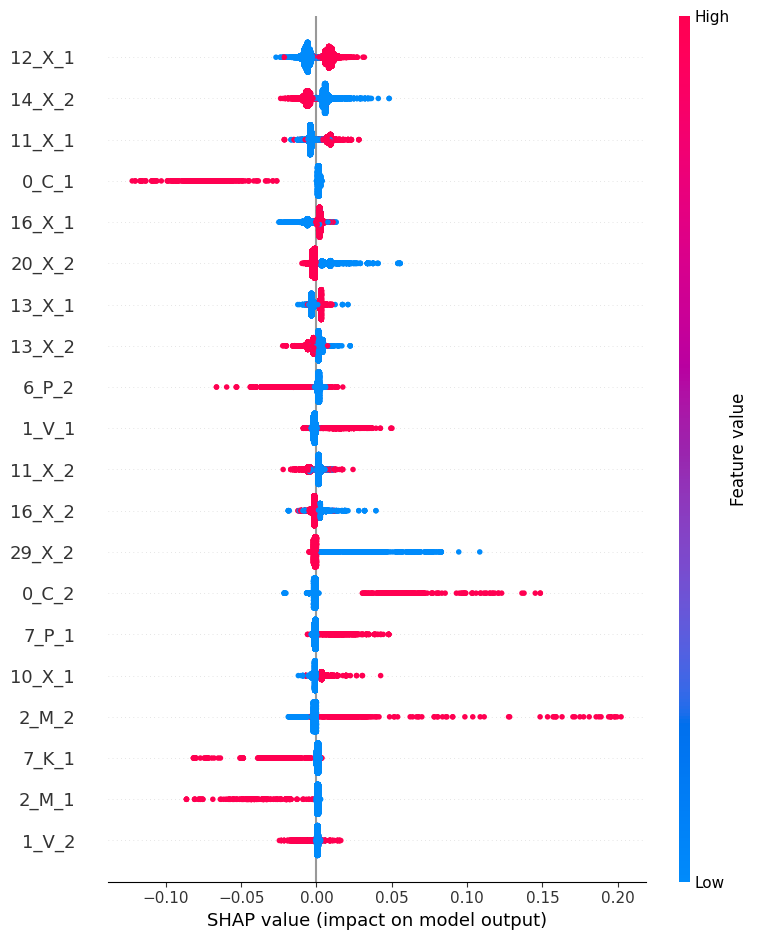

In [4]:
import shap

explainer = shap.TreeExplainer(reg)
explanation = explainer(X)

shap.summary_plot(explanation)

In [5]:
from sklearn.preprocessing import StandardScaler

data_sepsis = pd.read_csv("data/data_sepsis.tsv", sep="\t")
design_sepsis = pd.read_csv("data/design_sepsis.tsv", sep="\t")
fg.add_dataset(data_sepsis, design_sepsis)

X, y = fg.generate_pair_matrix()

print(X.shape)

reg = XGBRegressor()
reg.fit(X, y.values)

Dataset 0
Dataset 1
Concatenating
(59179, 2100)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

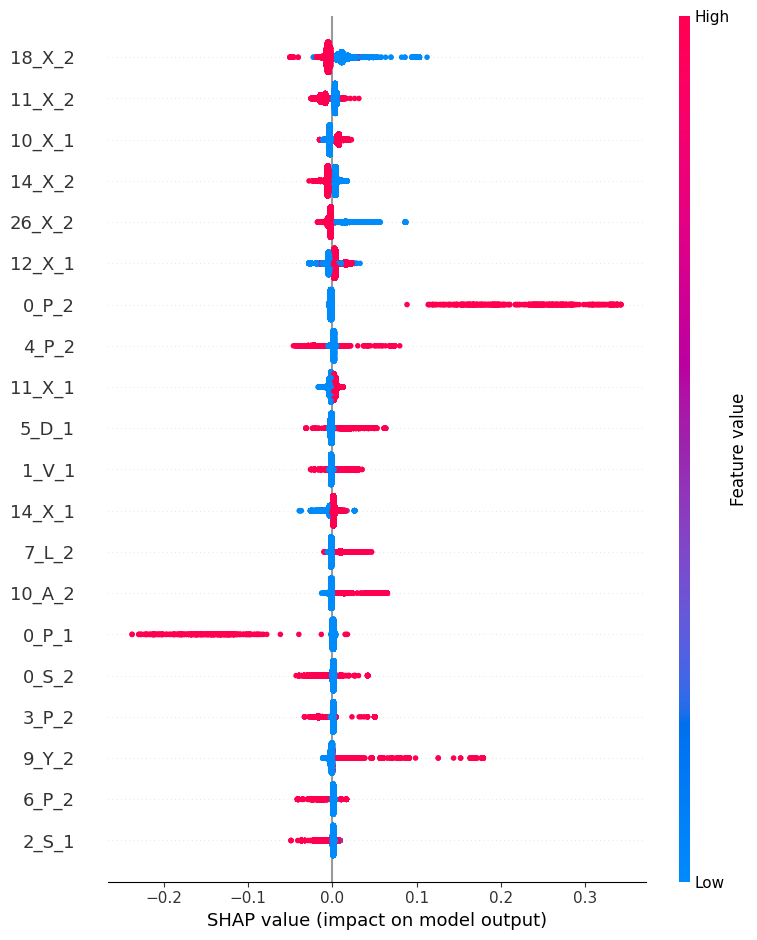

In [6]:
explainer = shap.TreeExplainer(reg)
explanation = explainer(X)

shap.summary_plot(explanation)

0.8514466773678304 0.0 0.5805876625381982 0.17679389089825953


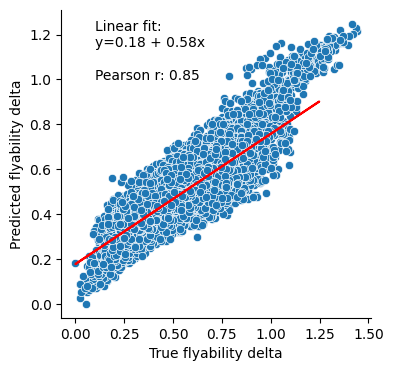

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.figure(figsize=(4,4))

y_predict = reg.predict(X)
y_predict = y_predict - min(y_predict)
y_all = y - min(y)

pearson_corr, pval = stats.pearsonr(y_all, y_predict)
slope, intercept = np.polyfit(y_all, y_predict, 1)

print(pearson_corr, pval, slope, intercept)
sns.scatterplot(x=y_all, y=y_predict)
plt.annotate(f"Linear fit: \ny={intercept:.2f} + {slope:.2f}x \n\nPearson r: {pearson_corr:.2f}", xy=(0.1, 1))
plt.plot(y_predict, slope*y_predict + intercept, color='red', label=f'y={slope:.2f}x+{intercept:.2f}')


plt.xlabel("True flyability delta")
plt.ylabel("Predicted flyability delta")
sns.despine()

<Axes: ylabel='Count'>

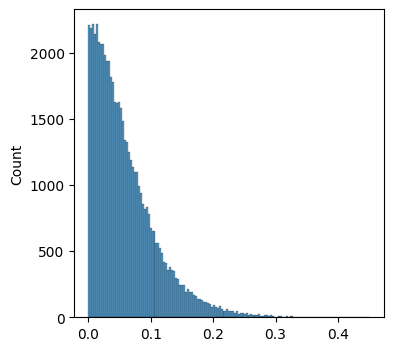

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(4,4))
sns.histplot(np.abs(y - reg.predict(X)))


In [9]:
shap.initjs()
i=100
print(X.index[i],y_all[i])
shap.plots.force(explanation[i])


AAS_P2009_167_sp|A2ARV4|LRP2_MOUSE_QDC(UniMod:4)ADGSDEDRVLC(UniMod:4)EHHR_EAVAVAPPPSPSLPAK 0.2766211572533479


/var/folders/64/ytcycnwx6w936vfxs5_7q3hm0000gn/T/ipykernel_10431/3556404716.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(X.index[i],y_all[i])


In [10]:
pd.read_csv("data/enzyme_data/trypsin/results.sage.tsv", sep="\t")

,psm_id,peptide,proteins,num_proteins,filename,scannr,rank,label,expmass,calcmass,...,longest_y_pct,matched_intensity_pct,scored_candidates,poisson,sage_discriminant_score,posterior_error,spectrum_q,peptide_q,protein_q,ms2_intensity
0,175908,TVSLGAGAKDELHIVEAEAMNYEGSPIK,sp|P06748|NPM_HUMAN,1,DT_M2105_476.mzML,controllerType=0 controllerNumber=1 scan=72072,1,1,2928.4636,2928.4536,...,0.500000,57.253765,8787,-34.596975,3.738927,1.0,0.000005,1.0,1.0,7778130.00
1,183417,NMGGPYGGGNYGPGGSGGSGGYGGR,sp|P22626|ROA2_HUMAN,1,DT_M2105_476.mzML,controllerType=0 controllerNumber=1 scan=39400,1,1,2188.9040,2188.8982,...,0.800000,64.232440,4550,-29.034218,3.669004,1.0,0.000005,1.0,1.0,3073397.50
2,7088,GGGGGGYGSGGSSYGSGGGSYGSGGGGGGGR,sp|P04264|K2C1_HUMAN,1,DT_M2105_462.mzML,controllerType=0 controllerNumber=1 scan=22662,1,1,2382.9473,2382.9446,...,0.516129,55.207764,3844,-31.610986,3.656692,1.0,0.000005,1.0,1.0,4044654.50
3,138394,FENAFLSHVVSQHQALLGTIR,sp|P25705|ATPA_HUMAN,1,DT_M2105_475.mzML,controllerType=0 controllerNumber=1 scan=67324,1,1,2366.2537,2366.2495,...,0.714286,51.998684,9155,-28.526409,3.623380,1.0,0.000005,1.0,1.0,9773440.00
4,15482,GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGK,sp|P35527|K1C9_HUMAN,1,DT_M2105_462.mzML,controllerType=0 controllerNumber=1 scan=24713,1,1,3222.2776,3222.2744,...,0.350000,64.675964,3189,-31.813410,3.607504,1.0,0.000005,1.0,1.0,2876812.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213204,182616,VTLQQQNSLEQWAAWLDGVVSQVLKPYQGSAGFPK,sp|P22670|RFX1_HUMAN,1,DT_M2105_476.mzML,controllerType=0 controllerNumber=1 scan=90029,1,1,3861.5444,3871.9895,...,0.028571,6.325856,3893,-3.016705,1.399986,1.0,0.000005,1.0,1.0,28815636.00
213205,71609,GPGLGVAGVAGAAGAGLPESVIWAVNAGGEAHVDVHGIHFR,sp|Q14165|MLEC_HUMAN,1,DT_M2105_468.mzML,controllerType=0 controllerNumber=1 scan=89735,1,1,3861.5566,3871.9863,...,0.000000,3.621510,3778,-3.042817,1.396942,1.0,0.000005,1.0,1.0,1581976.00
213206,186035,C[+57.0215]EYLMELMTPAAC[+57.0215]PEPPPEAPTEDDHDEL,sp|P14314|GLU2B_HUMAN,1,DT_M2105_476.mzML,controllerType=0 controllerNumber=1 scan=92826,1,1,3356.3975,3356.3860,...,0.068966,56.591553,117,-2.945027,1.395444,1.0,0.000005,1.0,1.0,135820.47
213207,162323,GPGLGVAGVAGAAGAGLPESVIWAVNAGGEAHVDVHGIHFR,sp|Q14165|MLEC_HUMAN,1,DT_M2105_475.mzML,controllerType=0 controllerNumber=1 scan=89958,1,1,3861.5166,3871.9863,...,0.000000,3.676156,3814,-3.031748,1.394200,1.0,0.000005,1.0,1.0,18635886.00
